Steps Involved-
1.General Architecture

2.Adding Symmetric Noise

3.Training and Testing on Symmetric Noise using Normalized Losses

4.Training and Testing on Symmetric Noise using Vanilla Counterparts

5.Training and Testing on Symmetric Noise using APL framework(NCE+MAE,NFL,MAE)

6.Bonus-All steps repeated with assymetric noise of 0.2,0.1.0.33,0.25


1)General Architecture

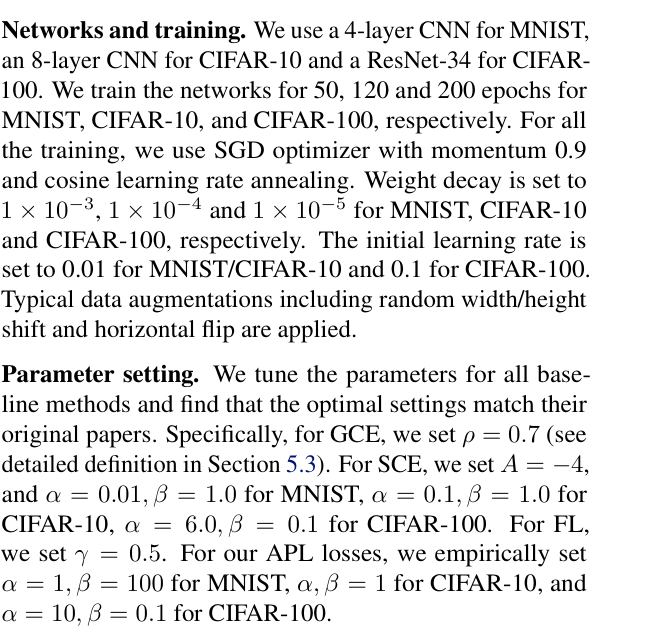

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
num_epoches=15
batch_size=4
learning_rate=0.0001


In [6]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [7]:
train_dataset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 73.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

In [10]:
classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # Downsampling

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Adjusted Fully Connected Layers
        self.fc1 = nn.Linear(512 * 8 * 8, 1024)  # Adjusted for 8x8 feature maps
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Dynamically flatten

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

2)Symmetric Noise Creation

In [12]:


labels = np.array(train_dataset.targets)
n_classes = 10

def create_transition_matrix(noise_rate, n_classes):
    T = np.full((n_classes, n_classes), noise_rate / (n_classes - 1))
    np.fill_diagonal(T, 1 - noise_rate)
    return T

def add_symmetric_noise(labels, noise_rate):
    noisy_labels = labels.copy()
    T = create_transition_matrix(noise_rate, n_classes)

    for i in range(len(labels)):
        original_label = labels[i]
        noisy_label = np.random.choice(np.arange(n_classes), p=T[original_label])
        noisy_labels[i] = noisy_label

    return noisy_labels

def add_symmetricnoise_traditional(labels, noiserate):
    noisy_labels = labels.copy()
    n_samples = len(labels)
    n_noisy = int(noiserate * n_samples)

    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)

    for i in noisy_indices:
        original_label = noisy_labels[i]
        noisy_label = np.random.choice([l for l in range(n_classes) if l != original_label])
        noisy_labels[i] = noisy_label

    return noisy_labels

noise_rates = [0.4, 0.5, 0.6, 0.7]

noisy_labels_dict = {}
noisy_labels_dict_trad = {}

for rate in noise_rates:
    noisy_labels_dict[rate] = add_symmetric_noise(labels, rate)
    noisy_labels_dict_trad[rate] = add_symmetricnoise_traditional(labels, rate)

for rate in noise_rates:
    print(noisy_labels_dict_trad[rate][:10])

[6 0 9 4 1 1 2 7 8 1]
[6 7 9 8 9 8 0 1 8 3]
[8 9 2 4 0 0 6 1 9 6]
[3 9 1 4 8 9 9 6 4 3]


3)Training and Testing For Normalized Losses

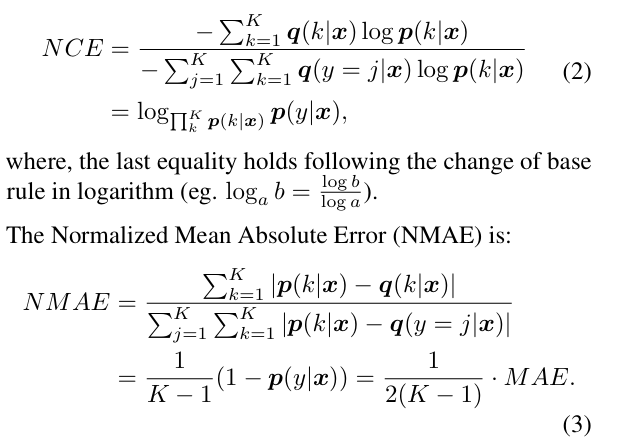

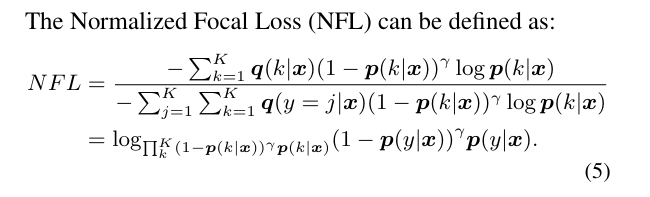

In [13]:
def normalizedcrossentropyloss(predictions,true_labels):
  e=1e-12
  predictions=np.clip(predictions,e,1-e)      # Ensure numerical stability

  q = np.eye(n_classes)[true_labels]

  num=np.sum(q*np.log(predictions),axis=1)
  den=np.sum(np.log(predictions),axis=1)

  nce_loss=-np.mean(num/den)
  return nce_loss


def normalizedfocalloss(predictions,true_labels,gamma=2):
  e=1e-12
  predictions=np.clip(predictions,e,1-e)
  q=np.eye(n_classes)[true_labels]

  num=np.sum(q*np.power(1-predictions,gamma)*np.log(predictions),axis=1)
  den=np.sum(np.power(1-predictions,gamma)*np.log(predictions),axis=1)
  ncl_loss=-np.mean(num/den)
  return ncl_loss


def MAE(predictions,true_labels,K=10):
  e=1e-12
  predictions=np.clip(predictions,e,1-e)      # Ensure numerical stability

  q = np.eye(n_classes)[true_labels]

  mae=np.mean(np.abs(predictions-q))

  nmae=(1 / (2 * (K - 1))) * mae

  return nmae


Noise Rate [0.4], Epoch [1/15], Step [2000/12500], Loss: -0.1006
Noise Rate [0.4], Epoch [1/15], Step [4000/12500], Loss: -0.1017
Noise Rate [0.4], Epoch [1/15], Step [6000/12500], Loss: -0.0998
Noise Rate [0.4], Epoch [1/15], Step [8000/12500], Loss: -0.0998
Noise Rate [0.4], Epoch [1/15], Step [10000/12500], Loss: -0.0999
Noise Rate [0.4], Epoch [1/15], Step [12000/12500], Loss: -0.1009
Noise Rate [0.4], Epoch [2/15], Step [2000/12500], Loss: -0.1006
Noise Rate [0.4], Epoch [2/15], Step [4000/12500], Loss: -0.1017
Noise Rate [0.4], Epoch [2/15], Step [6000/12500], Loss: -0.0998
Noise Rate [0.4], Epoch [2/15], Step [8000/12500], Loss: -0.0998
Noise Rate [0.4], Epoch [2/15], Step [10000/12500], Loss: -0.0999
Noise Rate [0.4], Epoch [2/15], Step [12000/12500], Loss: -0.1009
Noise Rate [0.4], Epoch [3/15], Step [2000/12500], Loss: -0.1006
Noise Rate [0.4], Epoch [3/15], Step [4000/12500], Loss: -0.1017
Noise Rate [0.4], Epoch [3/15], Step [6000/12500], Loss: -0.0998
Noise Rate [0.4], Epo

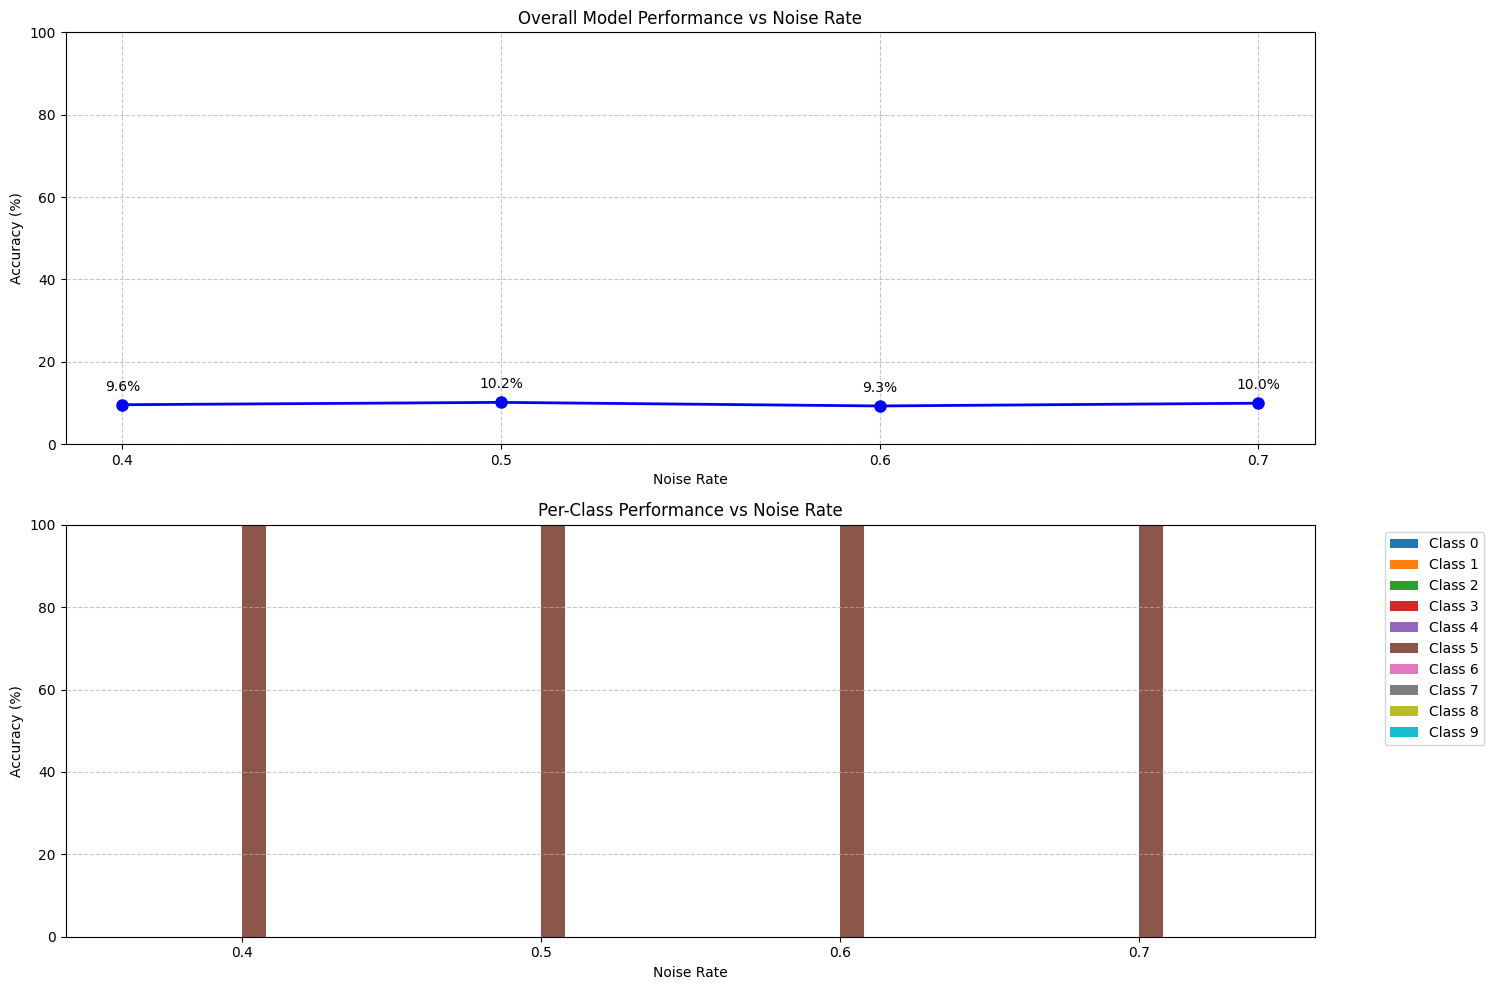


Numerical Results:

Overall Accuracy:
Noise Rate 0.4: 9.59%
Noise Rate 0.5: 10.16%
Noise Rate 0.6: 9.29%
Noise Rate 0.7: 9.96%

Per-Class Accuracy:

Class 0:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 1:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 2:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 3:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 4:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 5:
Noise Rate 0.4: 100.00%
Noise Rate 0.5: 100.00%
Noise Rate 0.6: 100.00%
Noise Rate 0.7: 100.00%

Class 6:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 7:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 8:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
accuracy_results = {}  # Initialize dictionary outside the loop

# Training loop
for rate in noise_rates:
    noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)
    noisy_labels_trad = torch.tensor(noisy_labels_dict_trad[rate]).to(device)

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch.cpu().numpy()
            noisy_labels_trad_np = noisy_labels_trad_batch.cpu().numpy()

            loss = normalizedcrossentropyloss(predictions, noisy_labels_np)
            loss_trad = normalizedcrossentropyloss(predictions, noisy_labels_trad_np)

            optimizer.zero_grad()
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')

# Evaluation loop
accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_rates:
        noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            noisy_labels_batch = noisy_labels[i * test_loader.batch_size : i * test_loader.batch_size + labels.size(0)].to(device)
            target_labels = noisy_labels_batch

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j]
                pred = predicted[j]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Store overall accuracy
        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        # Store per-class accuracies
        for i in range(10):
            if n_class_samples[i] != 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                class_accuracy_results[i][rate] = class_acc
            else:
                class_accuracy_results[i][rate] = 0  # or np.nan if you prefer

# Create a figure with two subplots
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy line plot
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

# Add value labels on points
for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Plot 2: Per-class accuracy bar plot
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different color for each class

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Noise Rate')
plt.xticks(x + width*4.5, x_values)  # Center the xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")



Noise Rate [0.4], Epoch [1/15], Step [2000/12500], Loss: -0.1010
Noise Rate [0.4], Epoch [1/15], Step [4000/12500], Loss: -0.1012
Noise Rate [0.4], Epoch [1/15], Step [6000/12500], Loss: -0.1013
Noise Rate [0.4], Epoch [1/15], Step [8000/12500], Loss: -0.0992
Noise Rate [0.4], Epoch [1/15], Step [10000/12500], Loss: -0.1001
Noise Rate [0.4], Epoch [1/15], Step [12000/12500], Loss: -0.1005
Noise Rate [0.4], Epoch [2/15], Step [2000/12500], Loss: -0.1010
Noise Rate [0.4], Epoch [2/15], Step [4000/12500], Loss: -0.1012
Noise Rate [0.4], Epoch [2/15], Step [6000/12500], Loss: -0.1013
Noise Rate [0.4], Epoch [2/15], Step [8000/12500], Loss: -0.0992
Noise Rate [0.4], Epoch [2/15], Step [10000/12500], Loss: -0.1001
Noise Rate [0.4], Epoch [2/15], Step [12000/12500], Loss: -0.1005
Noise Rate [0.4], Epoch [3/15], Step [2000/12500], Loss: -0.1010
Noise Rate [0.4], Epoch [3/15], Step [4000/12500], Loss: -0.1012
Noise Rate [0.4], Epoch [3/15], Step [6000/12500], Loss: -0.1013
Noise Rate [0.4], Epo

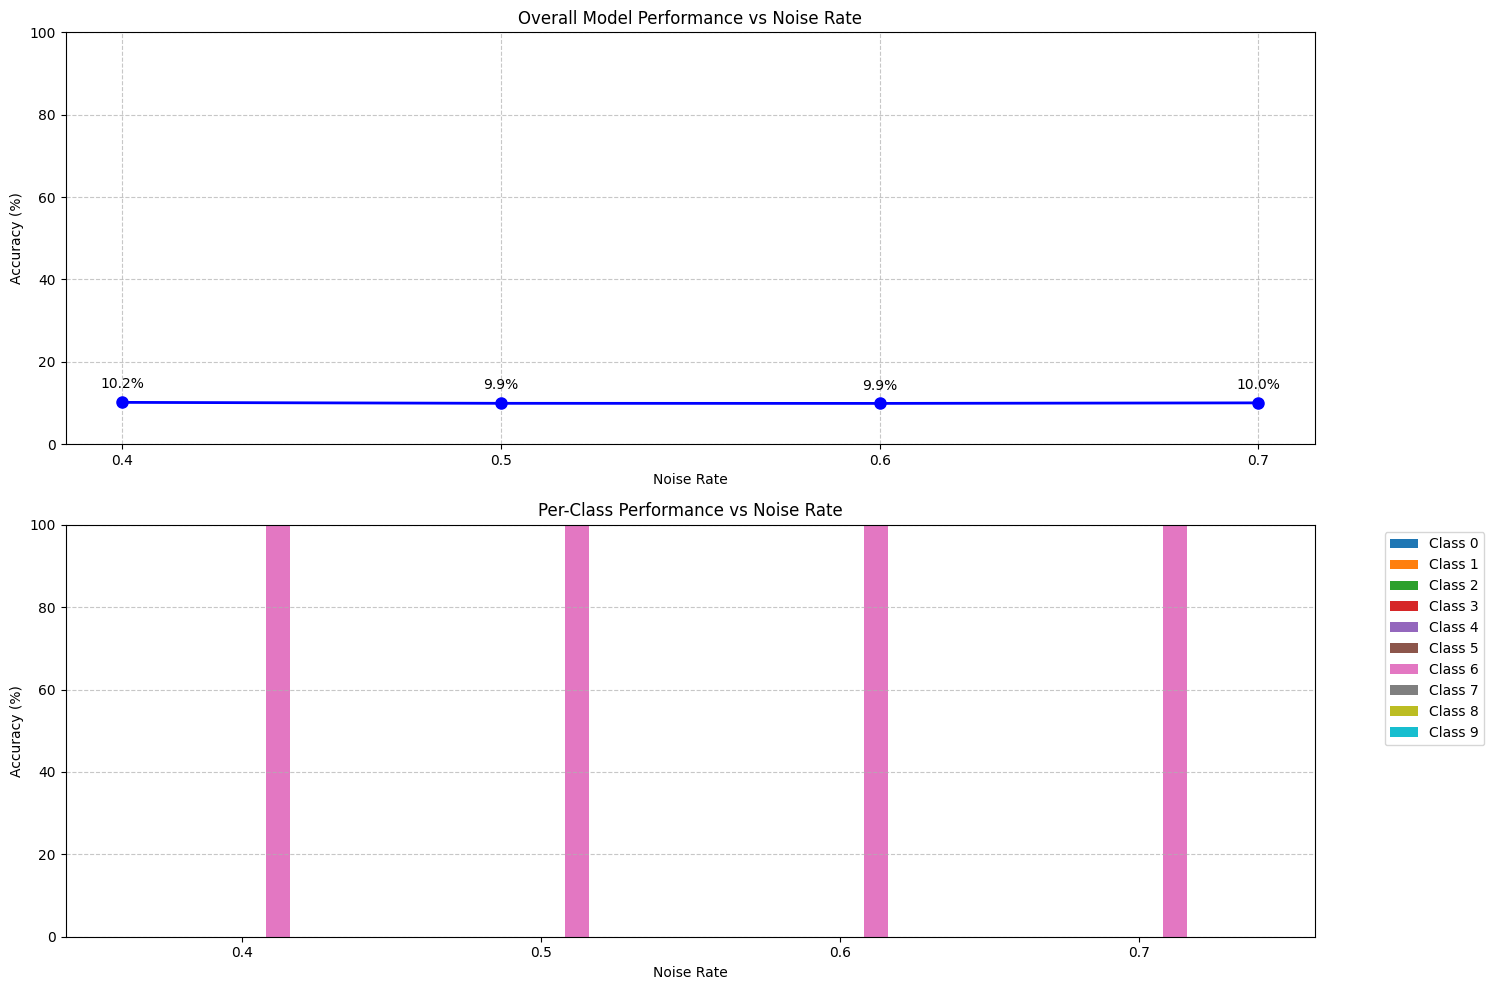


Numerical Results:

Overall Accuracy:
Noise Rate 0.4: 10.16%
Noise Rate 0.5: 9.93%
Noise Rate 0.6: 9.91%
Noise Rate 0.7: 10.04%

Per-Class Accuracy:

Class 0:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 1:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 2:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 3:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 4:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 5:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 6:
Noise Rate 0.4: 100.00%
Noise Rate 0.5: 100.00%
Noise Rate 0.6: 100.00%
Noise Rate 0.7: 100.00%

Class 7:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 8:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Nois

In [32]:
#Training and testing on Normalized Focal Loss
import torch
import numpy as np
import matplotlib.pyplot as plt

model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
accuracy_results = {}  # Initialize dictionary outside the loop

# Training loop
for rate in noise_rates:
    noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)
    noisy_labels_trad = torch.tensor(noisy_labels_dict_trad[rate]).to(device)

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch.cpu().numpy()
            noisy_labels_trad_np = noisy_labels_trad_batch.cpu().numpy()

            loss = normalizedfocalloss(predictions, noisy_labels_np)
            loss_trad = normalizedfocalloss(predictions, noisy_labels_trad_np)

            optimizer.zero_grad()
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')
accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

# Evaluation loop
with torch.no_grad():
    for rate in noise_rates:
        noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            noisy_labels_batch = noisy_labels[i * test_loader.batch_size : i * test_loader.batch_size + labels.size(0)].to(device)
            target_labels = noisy_labels_batch

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j]
                pred = predicted[j]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Store overall accuracy
        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        # Store per-class accuracies
        for i in range(10):
            if n_class_samples[i] != 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                class_accuracy_results[i][rate] = class_acc
            else:
                class_accuracy_results[i][rate] = 0  # or np.nan if you prefer

# Create a figure with two subplots
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy line plot
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

# Add value labels on points
for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Plot 2: Per-class accuracy bar plot
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different color for each class

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Noise Rate')
plt.xticks(x + width*4.5, x_values)  # Center the xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")

4)Vanilla Counterparts


<ipython-input-33-e63d89a8384e>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)


Noise Rate [0.4], Epoch [1/15], Step [2000/12500], Loss: 2.3052
Noise Rate [0.4], Epoch [1/15], Step [4000/12500], Loss: 2.3045
Noise Rate [0.4], Epoch [1/15], Step [6000/12500], Loss: 2.3039
Noise Rate [0.4], Epoch [1/15], Step [8000/12500], Loss: 2.3010
Noise Rate [0.4], Epoch [1/15], Step [10000/12500], Loss: 2.3016
Noise Rate [0.4], Epoch [1/15], Step [12000/12500], Loss: 2.3018
Noise Rate [0.4], Epoch [2/15], Step [2000/12500], Loss: 2.3052
Noise Rate [0.4], Epoch [2/15], Step [4000/12500], Loss: 2.3045
Noise Rate [0.4], Epoch [2/15], Step [6000/12500], Loss: 2.3039
Noise Rate [0.4], Epoch [2/15], Step [8000/12500], Loss: 2.3010
Noise Rate [0.4], Epoch [2/15], Step [10000/12500], Loss: 2.3016
Noise Rate [0.4], Epoch [2/15], Step [12000/12500], Loss: 2.3018
Noise Rate [0.4], Epoch [3/15], Step [2000/12500], Loss: 2.3052
Noise Rate [0.4], Epoch [3/15], Step [4000/12500], Loss: 2.3045
Noise Rate [0.4], Epoch [3/15], Step [6000/12500], Loss: 2.3039
Noise Rate [0.4], Epoch [3/15], Step

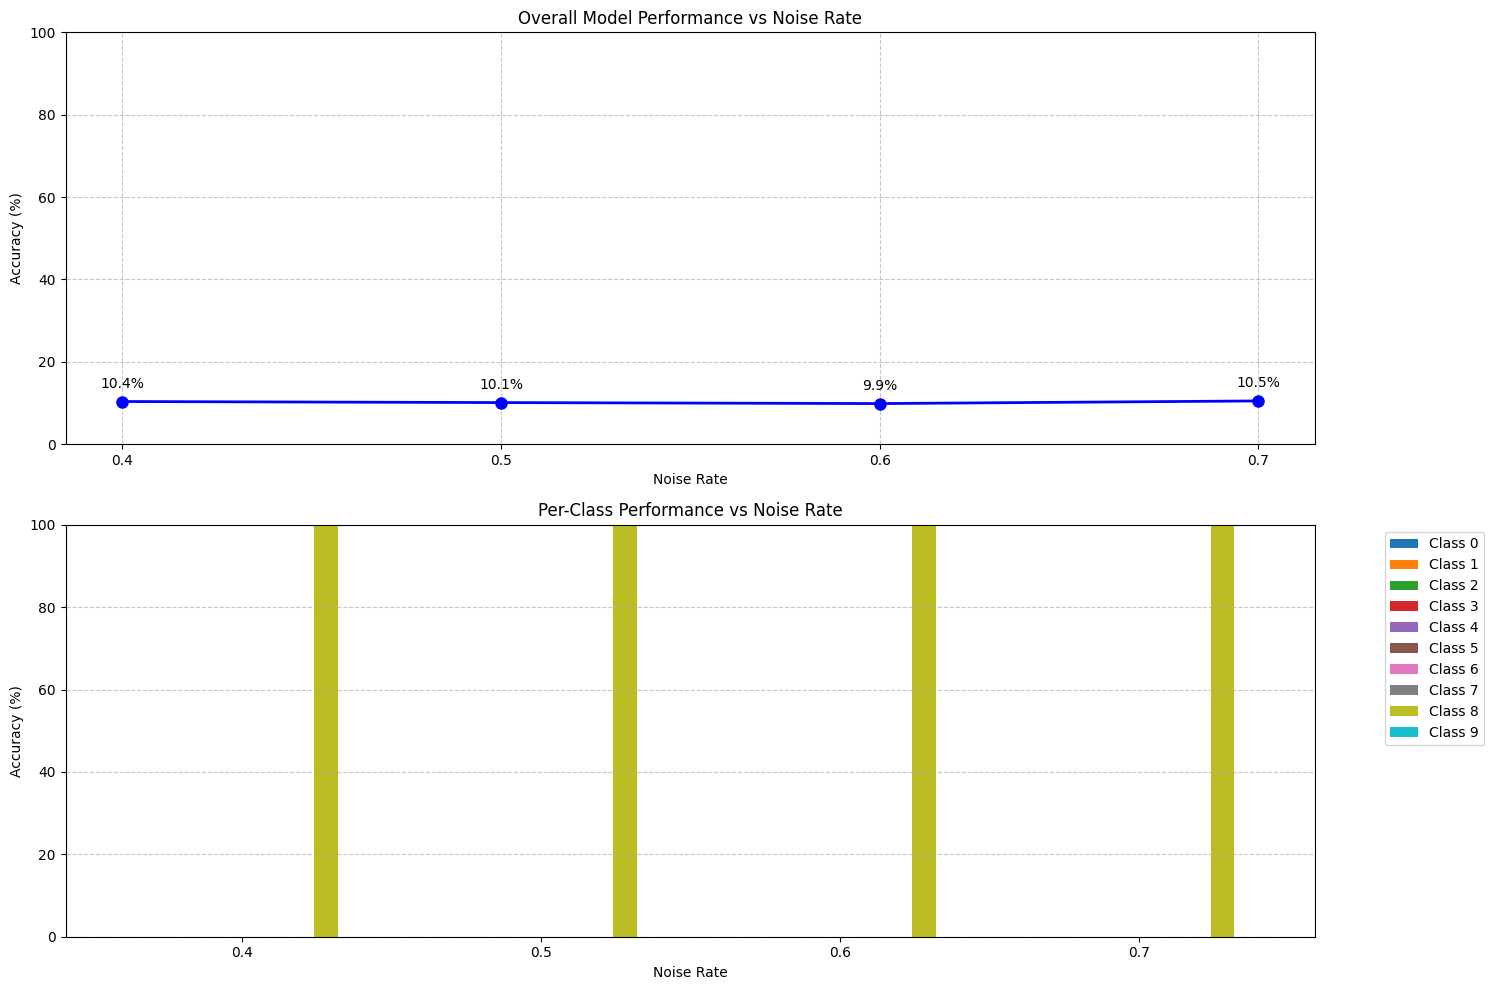


Numerical Results:

Overall Accuracy:
Noise Rate 0.4: 10.37%
Noise Rate 0.5: 10.11%
Noise Rate 0.6: 9.87%
Noise Rate 0.7: 10.51%

Per-Class Accuracy:

Class 0:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 1:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 2:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 3:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 4:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 5:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 6:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 7:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 8:
Noise Rate 0.4: 100.00%
Noise Rate 0.5: 100.00%
Noise R

In [33]:
#Cross Entropy Loss

model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
accuracy_results = {}  # Initialize dictionary outside the loop
criterion=nn.CrossEntropyLoss()
# Training loop
for rate in noise_rates:
    noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)
    noisy_labels_trad = torch.tensor(noisy_labels_dict_trad[rate]).to(device)

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1)

            noisy_labels_np = noisy_labels_batch
            noisy_labels_trad_np = noisy_labels_trad_batch

            loss = criterion(predictions, noisy_labels_np)
            loss_trad = criterion(predictions, noisy_labels_trad_np)

            optimizer.zero_grad()
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')

accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

# Evaluation loop
with torch.no_grad():
    for rate in noise_rates:
        noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            noisy_labels_batch = noisy_labels[i * test_loader.batch_size : i * test_loader.batch_size + labels.size(0)].to(device)
            target_labels = noisy_labels_batch

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j]
                pred = predicted[j]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Store overall accuracy
        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        # Store per-class accuracies
        for i in range(10):
            if n_class_samples[i] != 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                class_accuracy_results[i][rate] = class_acc
            else:
                class_accuracy_results[i][rate] = 0  # or np.nan if you prefer

# Create a figure with two subplots
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy line plot
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

# Add value labels on points
for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Plot 2: Per-class accuracy bar plot
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different color for each class

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Noise Rate')
plt.xticks(x + width*4.5, x_values)  # Center the xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha  # Optional weighting for class imbalance
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Apply softmax to get probabilities
        probs = F.softmax(inputs, dim=1)

        # Get the probabilities of the true class
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(1)).float()
        pt = (probs * targets_one_hot).sum(dim=1) + 1e-12  # To prevent log(0)

        # Apply alpha balancing if provided
        if self.alpha is not None:
            alpha_factor = self.alpha.gather(0, targets)
        else:
            alpha_factor = 1.0

        # Compute focal loss
        focal_weight = alpha_factor * (1 - pt) ** self.gamma
        loss = -focal_weight * torch.log(pt)


        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

<ipython-input-35-f6aebf93b3ef>:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)


Noise Rate [0.4], Epoch [1/15], Step [2000/12500], Loss: 1.8660
Noise Rate [0.4], Epoch [1/15], Step [4000/12500], Loss: 1.8619
Noise Rate [0.4], Epoch [1/15], Step [6000/12500], Loss: 1.8678
Noise Rate [0.4], Epoch [1/15], Step [8000/12500], Loss: 1.8626
Noise Rate [0.4], Epoch [1/15], Step [10000/12500], Loss: 1.8649
Noise Rate [0.4], Epoch [1/15], Step [12000/12500], Loss: 1.8616
Noise Rate [0.4], Epoch [2/15], Step [2000/12500], Loss: 1.8660
Noise Rate [0.4], Epoch [2/15], Step [4000/12500], Loss: 1.8619
Noise Rate [0.4], Epoch [2/15], Step [6000/12500], Loss: 1.8678
Noise Rate [0.4], Epoch [2/15], Step [8000/12500], Loss: 1.8626
Noise Rate [0.4], Epoch [2/15], Step [10000/12500], Loss: 1.8649
Noise Rate [0.4], Epoch [2/15], Step [12000/12500], Loss: 1.8616
Noise Rate [0.4], Epoch [3/15], Step [2000/12500], Loss: 1.8660
Noise Rate [0.4], Epoch [3/15], Step [4000/12500], Loss: 1.8619
Noise Rate [0.4], Epoch [3/15], Step [6000/12500], Loss: 1.8678
Noise Rate [0.4], Epoch [3/15], Step

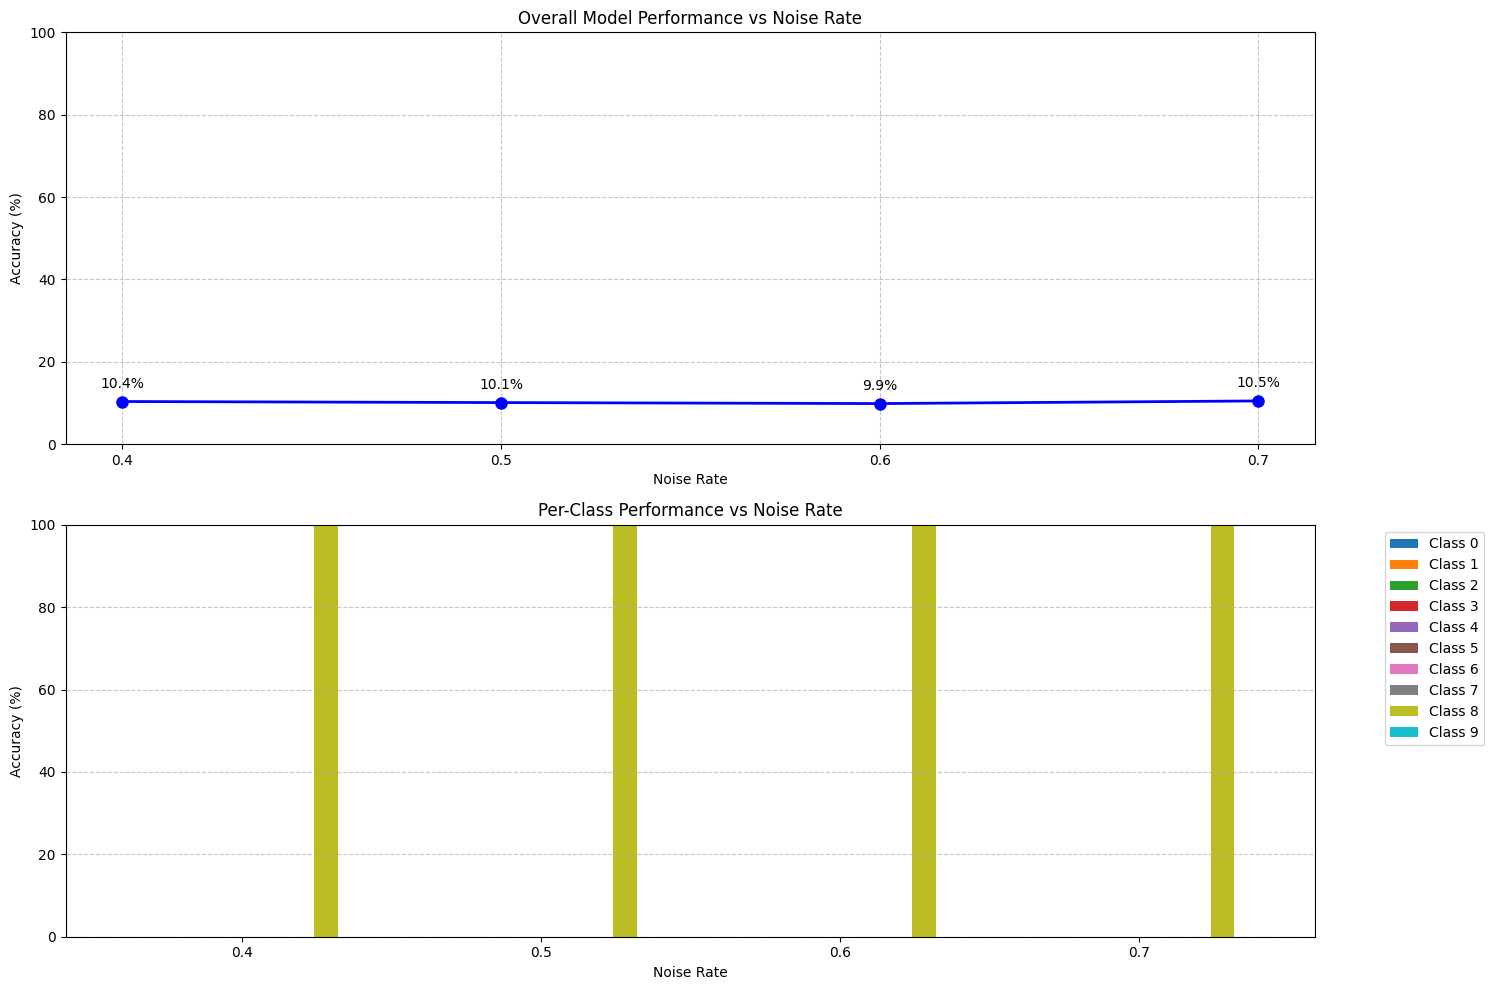


Numerical Results:

Overall Accuracy:
Noise Rate 0.4: 10.37%
Noise Rate 0.5: 10.11%
Noise Rate 0.6: 9.87%
Noise Rate 0.7: 10.51%

Per-Class Accuracy:

Class 0:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 1:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 2:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 3:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 4:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 5:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 6:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 7:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 8:
Noise Rate 0.4: 100.00%
Noise Rate 0.5: 100.00%
Noise R

In [35]:
#For focal Loss


model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = FocalLoss(gamma=2)
n_total_steps = len(train_loader)

for rate in noise_rates:
    noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)
    noisy_labels_trad = torch.tensor(noisy_labels_dict_trad[rate]).to(device)

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1)

            noisy_labels_np = noisy_labels_batch
            noisy_labels_trad_np = noisy_labels_trad_batch

            loss = criterion(predictions, noisy_labels_np)
            loss_trad = criterion(predictions, noisy_labels_trad_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')

accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

# Evaluation loop
accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}  # For storing per-class accuracies

# Evaluation loop
with torch.no_grad():
    for rate in noise_rates:
        noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            noisy_labels_batch = noisy_labels[i * test_loader.batch_size : i * test_loader.batch_size + labels.size(0)].to(device)
            target_labels = noisy_labels_batch

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j]
                pred = predicted[j]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Store overall accuracy
        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        # Store per-class accuracies
        for i in range(10):
            if n_class_samples[i] != 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                class_accuracy_results[i][rate] = class_acc
            else:
                class_accuracy_results[i][rate] = 0  # or np.nan if you prefer

# Create a figure with two subplots
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy line plot
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

# Add value labels on points
for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Plot 2: Per-class accuracy bar plot
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different color for each class

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Noise Rate')
plt.xticks(x + width*4.5, x_values)  # Center the xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")

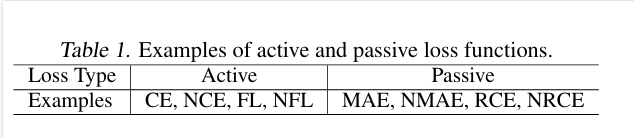


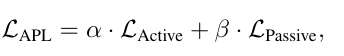

APL Framework


In [15]:
def APLNCEMAE(predictions,labels,a=1,b=1):
#a=1,b=1 are optimal as mentioned in the paper
  APL = a*normalizedcrossentropyloss(predictions,labels) + b * MAE(predictions,labels,10)
  return APL


Noise Rate [0.4], Epoch [1/15], Step [2000/12500], Loss: -0.0905
Noise Rate [0.4], Epoch [1/15], Step [4000/12500], Loss: -0.0906
Noise Rate [0.4], Epoch [1/15], Step [6000/12500], Loss: -0.0903
Noise Rate [0.4], Epoch [1/15], Step [8000/12500], Loss: -0.0894
Noise Rate [0.4], Epoch [1/15], Step [10000/12500], Loss: -0.0899
Noise Rate [0.4], Epoch [1/15], Step [12000/12500], Loss: -0.0899
Noise Rate [0.4], Epoch [2/15], Step [2000/12500], Loss: -0.0905
Noise Rate [0.4], Epoch [2/15], Step [4000/12500], Loss: -0.0906
Noise Rate [0.4], Epoch [2/15], Step [6000/12500], Loss: -0.0903
Noise Rate [0.4], Epoch [2/15], Step [8000/12500], Loss: -0.0894
Noise Rate [0.4], Epoch [2/15], Step [10000/12500], Loss: -0.0899
Noise Rate [0.4], Epoch [2/15], Step [12000/12500], Loss: -0.0899
Noise Rate [0.4], Epoch [3/15], Step [2000/12500], Loss: -0.0905
Noise Rate [0.4], Epoch [3/15], Step [4000/12500], Loss: -0.0906
Noise Rate [0.4], Epoch [3/15], Step [6000/12500], Loss: -0.0903
Noise Rate [0.4], Epo

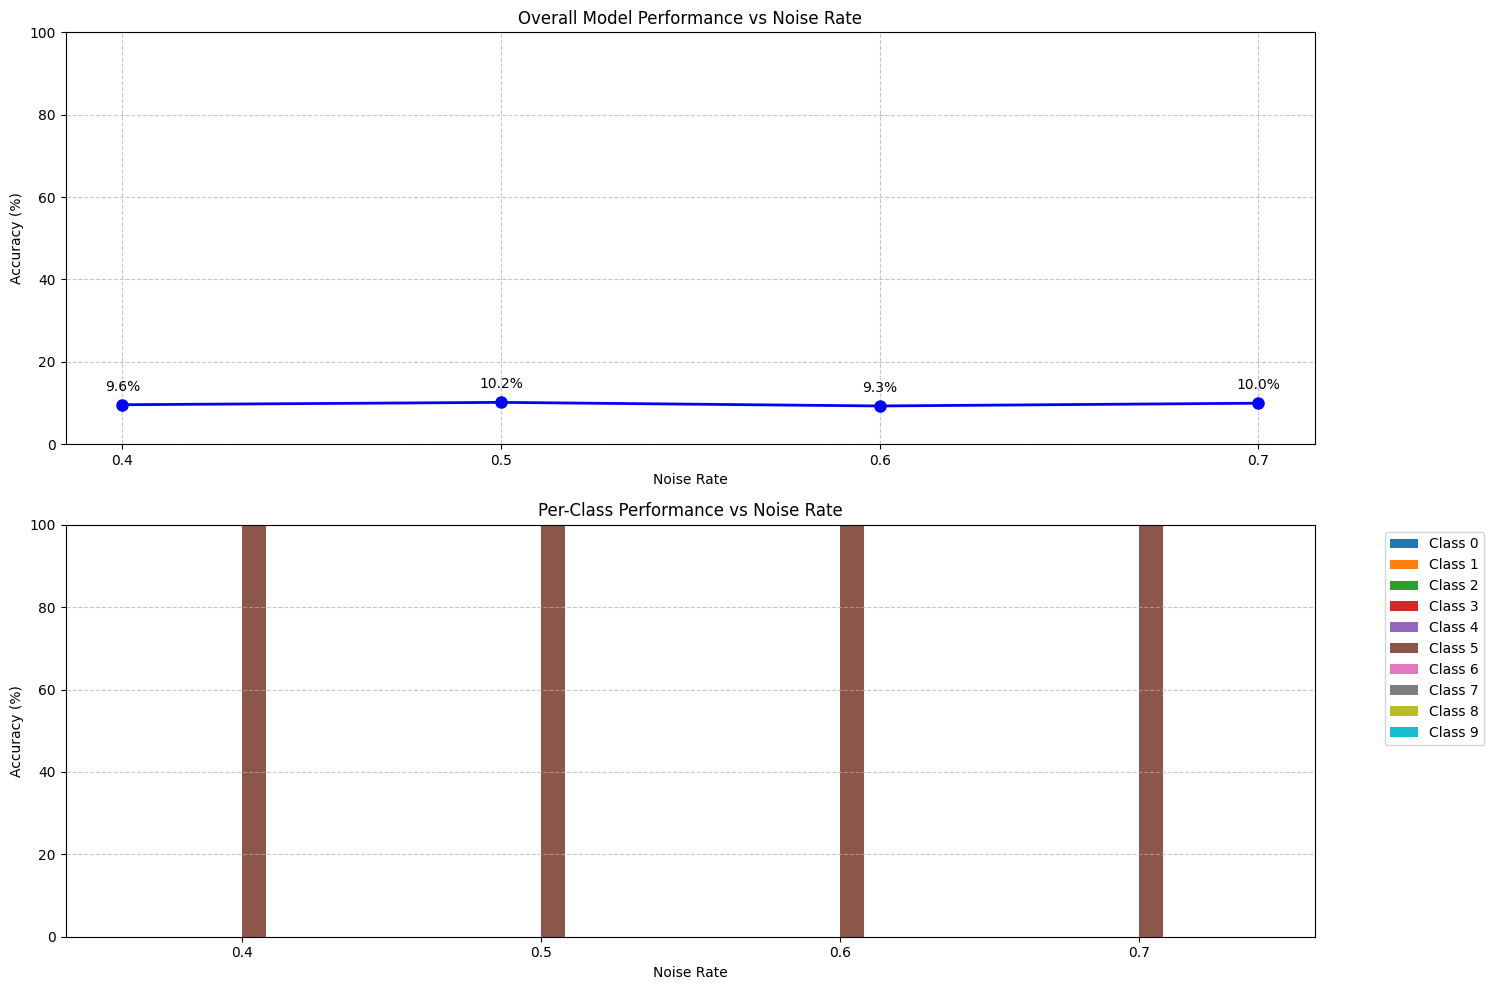


Numerical Results:

Overall Accuracy:
Noise Rate 0.4: 9.59%
Noise Rate 0.5: 10.16%
Noise Rate 0.6: 9.29%
Noise Rate 0.7: 9.96%

Per-Class Accuracy:

Class 0:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 1:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 2:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 3:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 4:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 5:
Noise Rate 0.4: 100.00%
Noise Rate 0.5: 100.00%
Noise Rate 0.6: 100.00%
Noise Rate 0.7: 100.00%

Class 6:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 7:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 8:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise

In [37]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

n_total_steps = len(train_loader)

for rate in noise_rates:
    noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)
    noisy_labels_trad = torch.tensor(noisy_labels_dict_trad[rate]).to(device)

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).cpu().detach().numpy()

            noisy_labels_np = noisy_labels_batch
            noisy_labels_trad_np = noisy_labels_trad_batch.cpu().detach().numpy()


            loss_trad = APLNCEMAE(predictions, noisy_labels_trad_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')

accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

# Evaluation loop
accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}  # For storing per-class accuracies

# Evaluation loop
with torch.no_grad():
    for rate in noise_rates:
        noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            noisy_labels_batch = noisy_labels[i * test_loader.batch_size : i * test_loader.batch_size + labels.size(0)].to(device)
            target_labels = noisy_labels_batch

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j]
                pred = predicted[j]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Store overall accuracy
        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        # Store per-class accuracies
        for i in range(10):
            if n_class_samples[i] != 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                class_accuracy_results[i][rate] = class_acc
            else:
                class_accuracy_results[i][rate] = 0  # or np.nan if you prefer

# Create a figure with two subplots
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy line plot
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

# Add value labels on points
for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Plot 2: Per-class accuracy bar plot
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different color for each class

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Noise Rate')
plt.xticks(x + width*4.5, x_values)  # Center the xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")

In [16]:
def APLNFLMAE(predictions,labels,a=1,b=1):
  APL = a*normalizedfocalloss(predictions,labels) + b * MAE(predictions,labels,10)
  return APL

Noise Rate [0.4], Epoch [1/15], Step [2000/12500], Loss: -0.0896
Noise Rate [0.4], Epoch [1/15], Step [4000/12500], Loss: -0.0898
Noise Rate [0.4], Epoch [1/15], Step [6000/12500], Loss: -0.0900
Noise Rate [0.4], Epoch [1/15], Step [8000/12500], Loss: -0.0895
Noise Rate [0.4], Epoch [1/15], Step [10000/12500], Loss: -0.0914
Noise Rate [0.4], Epoch [1/15], Step [12000/12500], Loss: -0.0902
Noise Rate [0.4], Epoch [2/15], Step [2000/12500], Loss: -0.0896
Noise Rate [0.4], Epoch [2/15], Step [4000/12500], Loss: -0.0898
Noise Rate [0.4], Epoch [2/15], Step [6000/12500], Loss: -0.0900
Noise Rate [0.4], Epoch [2/15], Step [8000/12500], Loss: -0.0895
Noise Rate [0.4], Epoch [2/15], Step [10000/12500], Loss: -0.0914
Noise Rate [0.4], Epoch [2/15], Step [12000/12500], Loss: -0.0902
Noise Rate [0.4], Epoch [3/15], Step [2000/12500], Loss: -0.0896
Noise Rate [0.4], Epoch [3/15], Step [4000/12500], Loss: -0.0898
Noise Rate [0.4], Epoch [3/15], Step [6000/12500], Loss: -0.0900
Noise Rate [0.4], Epo

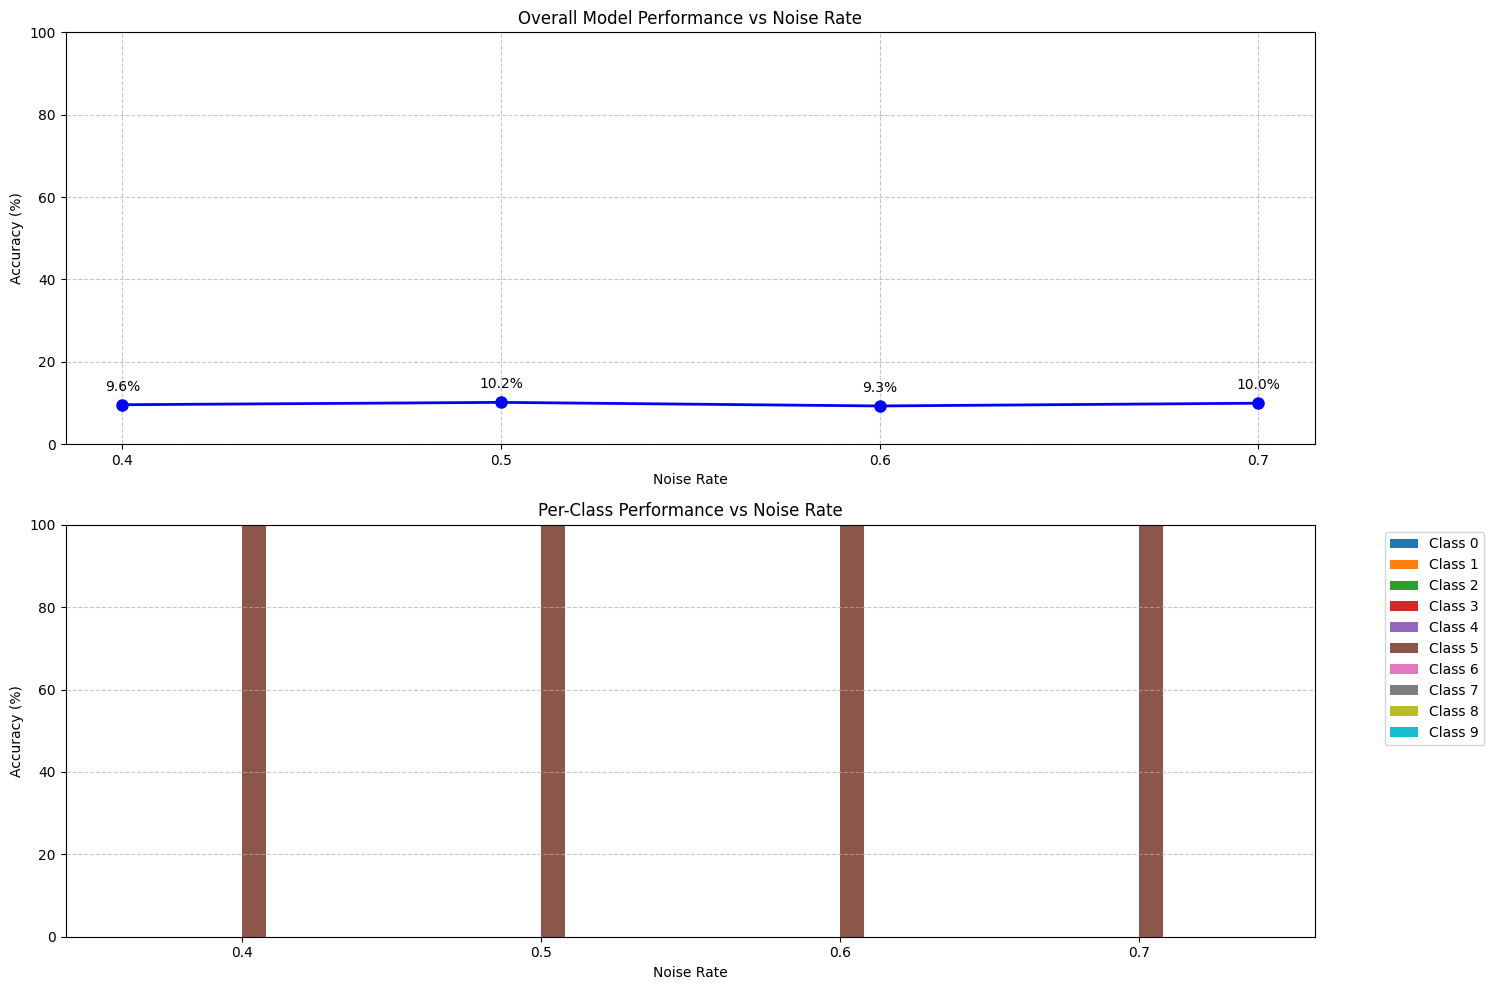


Numerical Results:

Overall Accuracy:
Noise Rate 0.4: 9.59%
Noise Rate 0.5: 10.16%
Noise Rate 0.6: 9.29%
Noise Rate 0.7: 9.96%

Per-Class Accuracy:

Class 0:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 1:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 2:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 3:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 4:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 5:
Noise Rate 0.4: 100.00%
Noise Rate 0.5: 100.00%
Noise Rate 0.6: 100.00%
Noise Rate 0.7: 100.00%

Class 6:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 7:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise Rate 0.6: 0.00%
Noise Rate 0.7: 0.00%

Class 8:
Noise Rate 0.4: 0.00%
Noise Rate 0.5: 0.00%
Noise

In [39]:
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)

for rate in noise_rates:
    noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)
    noisy_labels_trad = torch.tensor(noisy_labels_dict_trad[rate]).to(device)

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch
            noisy_labels_trad_np = noisy_labels_trad_batch.detach().cpu().numpy()

            loss_trad = APLNFLMAE(predictions, noisy_labels_trad_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')
accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}  # For storing per-class accuracies

# Evaluation loop
with torch.no_grad():
    for rate in noise_rates:
        noisy_labels = torch.tensor(noisy_labels_dict[rate]).to(device)

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            noisy_labels_batch = noisy_labels[i * test_loader.batch_size : i * test_loader.batch_size + labels.size(0)].to(device)
            target_labels = noisy_labels_batch

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j]
                pred = predicted[j]
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Store overall accuracy
        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        # Store per-class accuracies
        for i in range(10):
            if n_class_samples[i] != 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                class_accuracy_results[i][rate] = class_acc
            else:
                class_accuracy_results[i][rate] = 0  # or np.nan if you prefer

# Create a figure with two subplots
plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy line plot
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

# Add value labels on points
for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')

# Plot 2: Per-class accuracy bar plot
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08  # Width of bars
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different color for each class

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Noise Rate')
plt.xticks(x + width*4.5, x_values)  # Center the xticks
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")

6)Asymmetric noise refers to a type of label noise in machine learning where the incorrect labels are not randomly assigned but follow a specific pattern. Unlike symmetric noise, where any label can be flipped to any other label with equal probability, asymmetric noise introduces label corruption in a structured manner. This often mimics real-world label corruption, such as human annotation errors or systematic biases

In [17]:
import numpy as np
import torch
from torchvision import datasets, transforms

# Load CIFAR-10 trainset
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Extract labels from trainset
labels = np.array(trainset.targets)

def add_asymmetric_noise_multiple(labels, num_classes=10):
    labels = np.array(labels)

    # Define asymmetric noise mapping (CIFAR-10 example)
    class_mapping = {
        0: 2,  # Airplane → Bird
        1: 7,  # Automobile → Truck
        2: 0,  # Bird → Airplane
        3: 5,  # Cat → Dog
        4: 7,  # Deer → Horse
        5: 3,  # Dog → Cat
        6: 4,  # Frog → Deer
        7: 1,  # Horse → Automobile
        8: 9,  # Ship → Truck
        9: 8,  # Truck → Ship
    }

    noisy_labels_dict = {}
    noise_levels = [0.2, 0.1, 0.33, 0.23]
    for noise_level in noise_levels:
        noisy_labels = labels.copy()
        num_noisy = int(noise_level * len(labels))
        noisy_indices = np.random.choice(len(labels), num_noisy, replace=False)

        for idx in noisy_indices:
            original_label = labels[idx]
            if original_label in class_mapping:
                noisy_labels[idx] = class_mapping[original_label]

        noisy_labels_dict[noise_level] = noisy_labels

    return noisy_labels_dict

# Apply asymmetric noise
noisy_labels_dict2 = add_asymmetric_noise_multiple(labels)

# Print sample output
for noise_level, noisy_labels in noisy_labels_dict.items():
    print(f"Noisy Labels for Noise Rate {noise_level}:")
    print(noisy_labels[:20])


Files already downloaded and verified
Noisy Labels for Noise Rate 0.4:
[1 4 9 4 5 1 2 7 8 3 4 7 8 7 8 9 9 3 2 6]
Noisy Labels for Noise Rate 0.5:
[6 2 8 1 1 1 2 7 1 9 4 7 5 2 9 9 9 3 2 2]
Noisy Labels for Noise Rate 0.6:
[4 0 1 0 0 0 5 1 8 7 4 7 7 8 1 4 1 3 2 6]
Noisy Labels for Noise Rate 0.7:
[6 7 9 5 1 4 3 0 1 6 3 5 7 2 4 9 9 3 2 6]


Noise Rate [0.2], Epoch [1/15], Step [2000/12500], Loss: 2.2847
Noise Rate [0.2], Epoch [1/15], Step [4000/12500], Loss: 2.2363
Noise Rate [0.2], Epoch [1/15], Step [6000/12500], Loss: 2.4737
Noise Rate [0.2], Epoch [1/15], Step [8000/12500], Loss: 2.2915
Noise Rate [0.2], Epoch [1/15], Step [10000/12500], Loss: 2.2917
Noise Rate [0.2], Epoch [1/15], Step [12000/12500], Loss: 2.1799
Noise Rate [0.2], Epoch [2/15], Step [2000/12500], Loss: 2.2847
Noise Rate [0.2], Epoch [2/15], Step [4000/12500], Loss: 2.2363
Noise Rate [0.2], Epoch [2/15], Step [6000/12500], Loss: 2.4737
Noise Rate [0.2], Epoch [2/15], Step [8000/12500], Loss: 2.2915
Noise Rate [0.2], Epoch [2/15], Step [10000/12500], Loss: 2.2917
Noise Rate [0.2], Epoch [2/15], Step [12000/12500], Loss: 2.1799
Noise Rate [0.2], Epoch [3/15], Step [2000/12500], Loss: 2.2847
Noise Rate [0.2], Epoch [3/15], Step [4000/12500], Loss: 2.2363
Noise Rate [0.2], Epoch [3/15], Step [6000/12500], Loss: 2.4737
Noise Rate [0.2], Epoch [3/15], Step

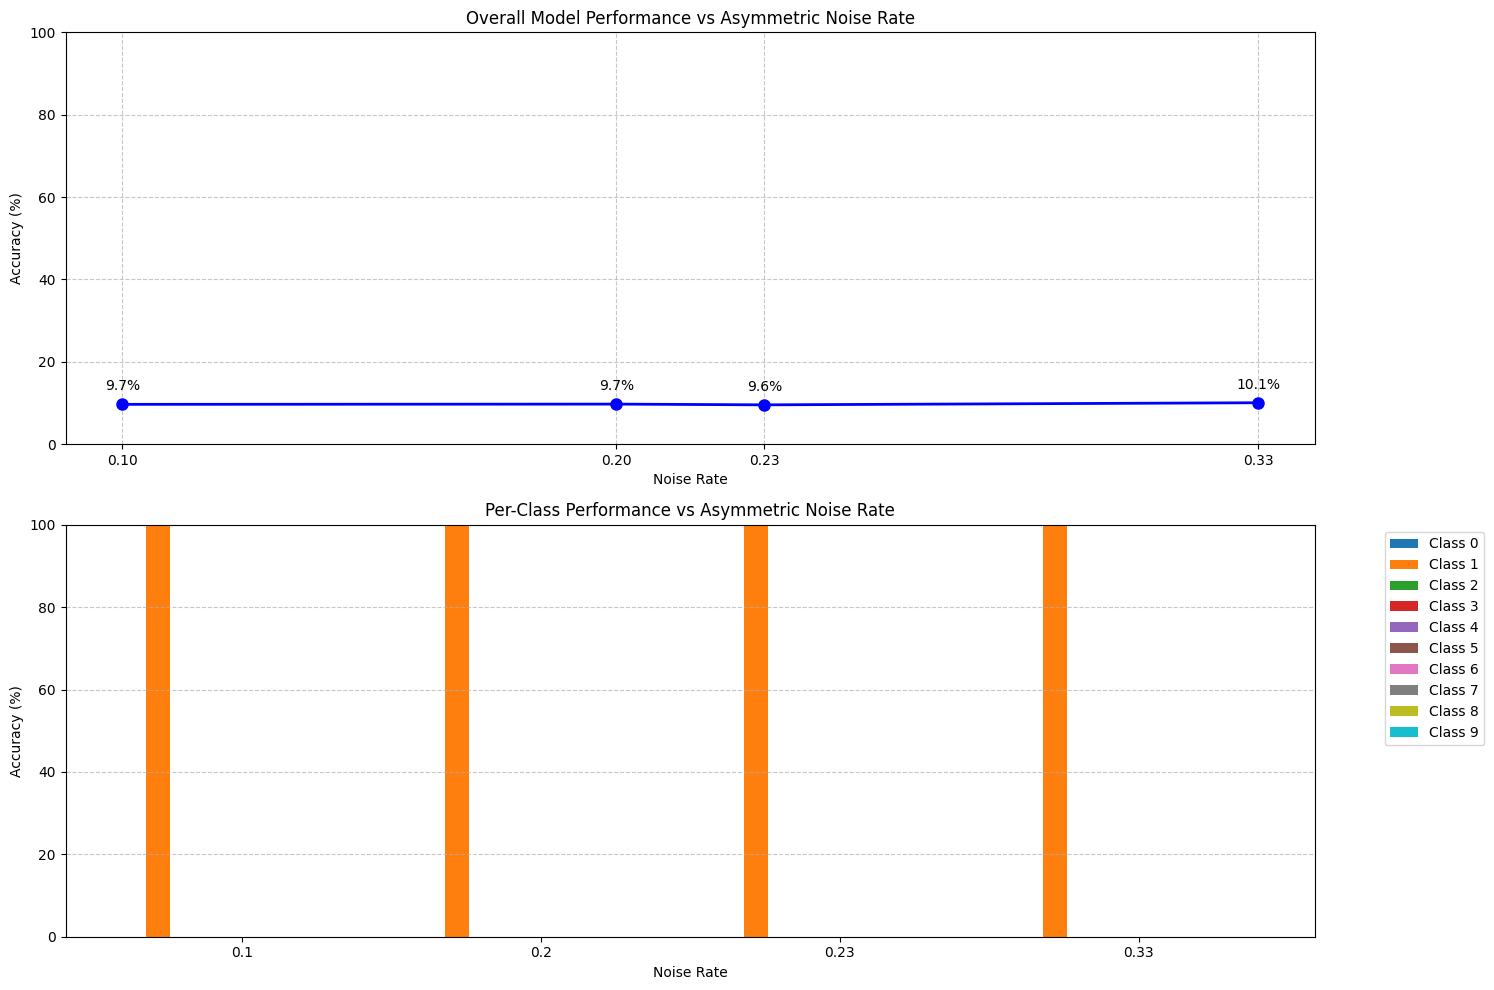


Numerical Results:

Overall Accuracy:
Noise Rate 0.1: 9.68%
Noise Rate 0.2: 9.74%
Noise Rate 0.23: 9.56%
Noise Rate 0.33: 10.07%

Per-Class Accuracy:

Class 0:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 1:
Noise Rate 0.1: 100.00%
Noise Rate 0.2: 100.00%
Noise Rate 0.23: 100.00%
Noise Rate 0.33: 100.00%

Class 2:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 3:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 4:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 5:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 6:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 7:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 8:
Noise Rate 0.1: 0.00%
Noise Rat

In [41]:
#For crossentropy loss-


model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
n_total_steps = len(train_loader)
noise_levels = [0.2, 0.1, 0.33, 0.23]
for rate in noise_levels:
    noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * train_loader.batch_size
            batch_end = batch_start + images.size(0)
            noisy_labels_batch = noisy_labels[batch_start:batch_end]  # Get batch noisy labels

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, noisy_labels_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training with Asymmetric Noisy Labels!')

accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_levels:
        noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * test_loader.batch_size
            batch_end = batch_start + labels.size(0)
            target_labels = noisy_labels[batch_start:batch_end]

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j].item()
                pred = predicted[j].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        for i in range(10):
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] != 0 else 0
            class_accuracy_results[i][rate] = class_acc

plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Asymmetric Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: Per-class accuracy
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Asymmetric Noise Rate')
plt.xticks(x + width*4.5, x_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


Noise Rate [0.2], Epoch [1/15], Step [2000/12500], Loss: -0.0997
Noise Rate [0.2], Epoch [1/15], Step [4000/12500], Loss: -0.0994
Noise Rate [0.2], Epoch [1/15], Step [6000/12500], Loss: -0.1000
Noise Rate [0.2], Epoch [1/15], Step [8000/12500], Loss: -0.1011
Noise Rate [0.2], Epoch [1/15], Step [10000/12500], Loss: -0.1003
Noise Rate [0.2], Epoch [1/15], Step [12000/12500], Loss: -0.0997
Noise Rate [0.2], Epoch [2/15], Step [2000/12500], Loss: -0.0997
Noise Rate [0.2], Epoch [2/15], Step [4000/12500], Loss: -0.0994
Noise Rate [0.2], Epoch [2/15], Step [6000/12500], Loss: -0.1000
Noise Rate [0.2], Epoch [2/15], Step [8000/12500], Loss: -0.1011
Noise Rate [0.2], Epoch [2/15], Step [10000/12500], Loss: -0.1003
Noise Rate [0.2], Epoch [2/15], Step [12000/12500], Loss: -0.0997
Noise Rate [0.2], Epoch [3/15], Step [2000/12500], Loss: -0.0997
Noise Rate [0.2], Epoch [3/15], Step [4000/12500], Loss: -0.0994
Noise Rate [0.2], Epoch [3/15], Step [6000/12500], Loss: -0.1000
Noise Rate [0.2], Epo

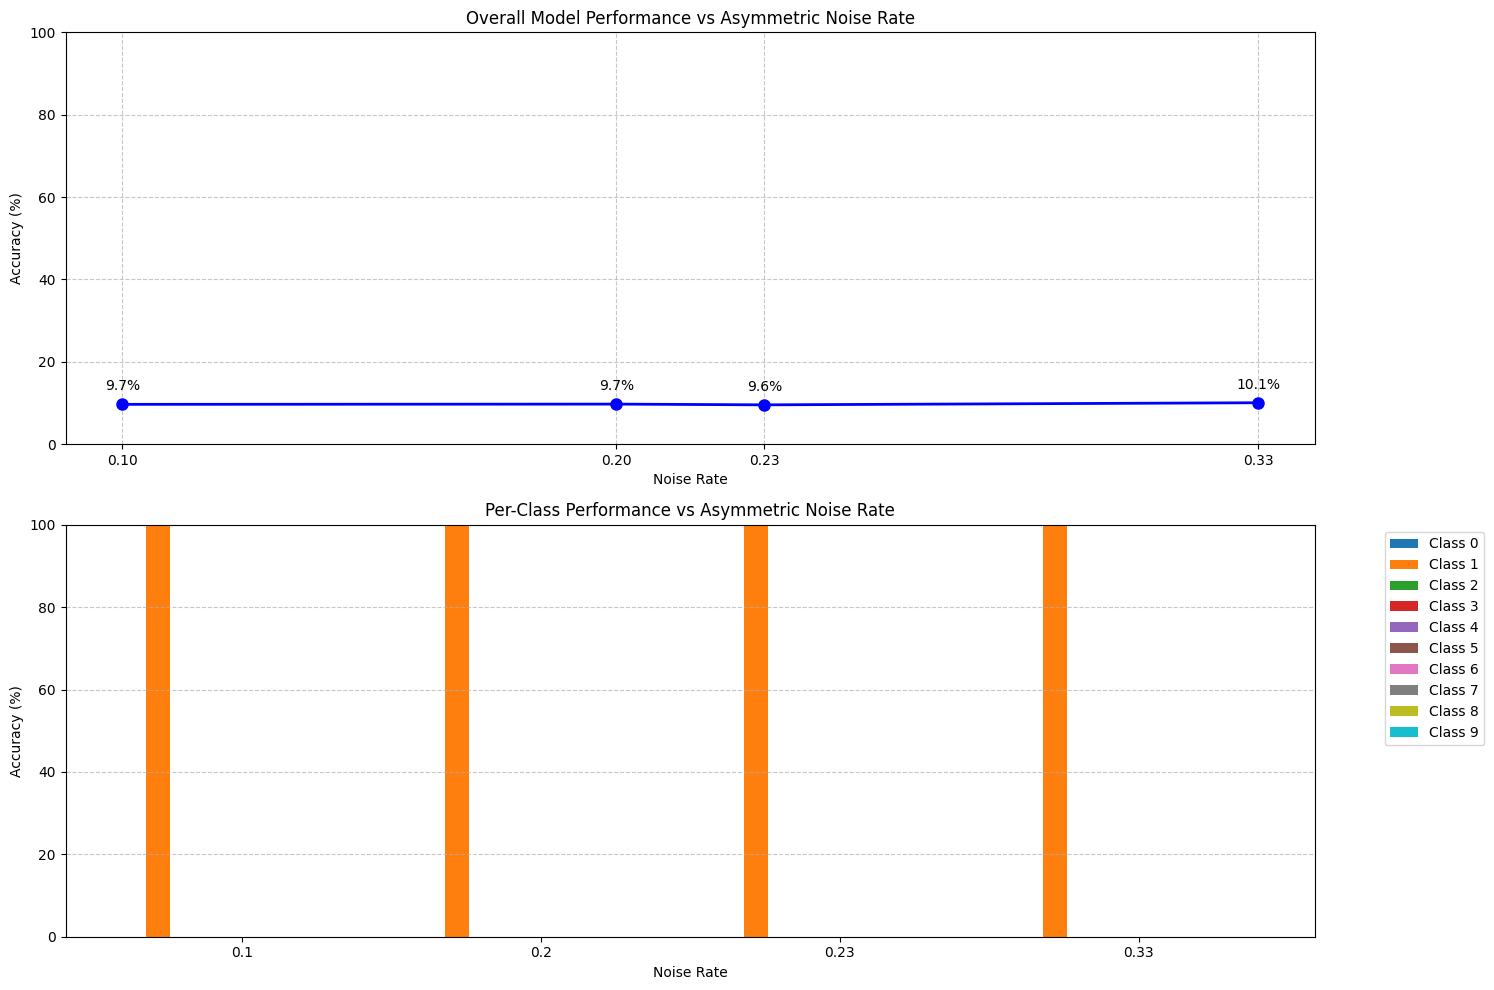


Numerical Results:

Overall Accuracy:
Noise Rate 0.1: 9.68%
Noise Rate 0.2: 9.74%
Noise Rate 0.23: 9.56%
Noise Rate 0.33: 10.07%

Per-Class Accuracy:

Class 0:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 1:
Noise Rate 0.1: 100.00%
Noise Rate 0.2: 100.00%
Noise Rate 0.23: 100.00%
Noise Rate 0.33: 100.00%

Class 2:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 3:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 4:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 5:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 6:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 7:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 8:
Noise Rate 0.1: 0.00%
Noise Rat

In [42]:
#Normalized Cross Entropy Loss
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
noise_levels = [0.2, 0.1, 0.33, 0.23]
for rate in noise_levels:
    noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            noisy_labels_trad_batch = noisy_labels_trad[batch_indices]

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch.detach().cpu().numpy()
            noisy_labels_trad_np = noisy_labels_trad_batch.detach().cpu().numpy()

            loss_trad = normalizedcrossentropyloss(predictions, noisy_labels_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')


accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_levels:
        noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * test_loader.batch_size
            batch_end = batch_start + labels.size(0)
            target_labels = noisy_labels[batch_start:batch_end]

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j].item()
                pred = predicted[j].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        for i in range(10):
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] != 0 else 0
            class_accuracy_results[i][rate] = class_acc

plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Asymmetric Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: Per-class accuracy
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Asymmetric Noise Rate')
plt.xticks(x + width*4.5, x_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


Noise Rate [0.2], Epoch [1/15], Step [2000/12500], Loss: -0.1005
Noise Rate [0.2], Epoch [1/15], Step [4000/12500], Loss: -0.1005
Noise Rate [0.2], Epoch [1/15], Step [6000/12500], Loss: -0.1000
Noise Rate [0.2], Epoch [1/15], Step [8000/12500], Loss: -0.0993
Noise Rate [0.2], Epoch [1/15], Step [10000/12500], Loss: -0.1004
Noise Rate [0.2], Epoch [1/15], Step [12000/12500], Loss: -0.1000
Noise Rate [0.2], Epoch [2/15], Step [2000/12500], Loss: -0.1005
Noise Rate [0.2], Epoch [2/15], Step [4000/12500], Loss: -0.1005
Noise Rate [0.2], Epoch [2/15], Step [6000/12500], Loss: -0.1000
Noise Rate [0.2], Epoch [2/15], Step [8000/12500], Loss: -0.0993
Noise Rate [0.2], Epoch [2/15], Step [10000/12500], Loss: -0.1004
Noise Rate [0.2], Epoch [2/15], Step [12000/12500], Loss: -0.1000
Noise Rate [0.2], Epoch [3/15], Step [2000/12500], Loss: -0.1005
Noise Rate [0.2], Epoch [3/15], Step [4000/12500], Loss: -0.1005
Noise Rate [0.2], Epoch [3/15], Step [6000/12500], Loss: -0.1000
Noise Rate [0.2], Epo

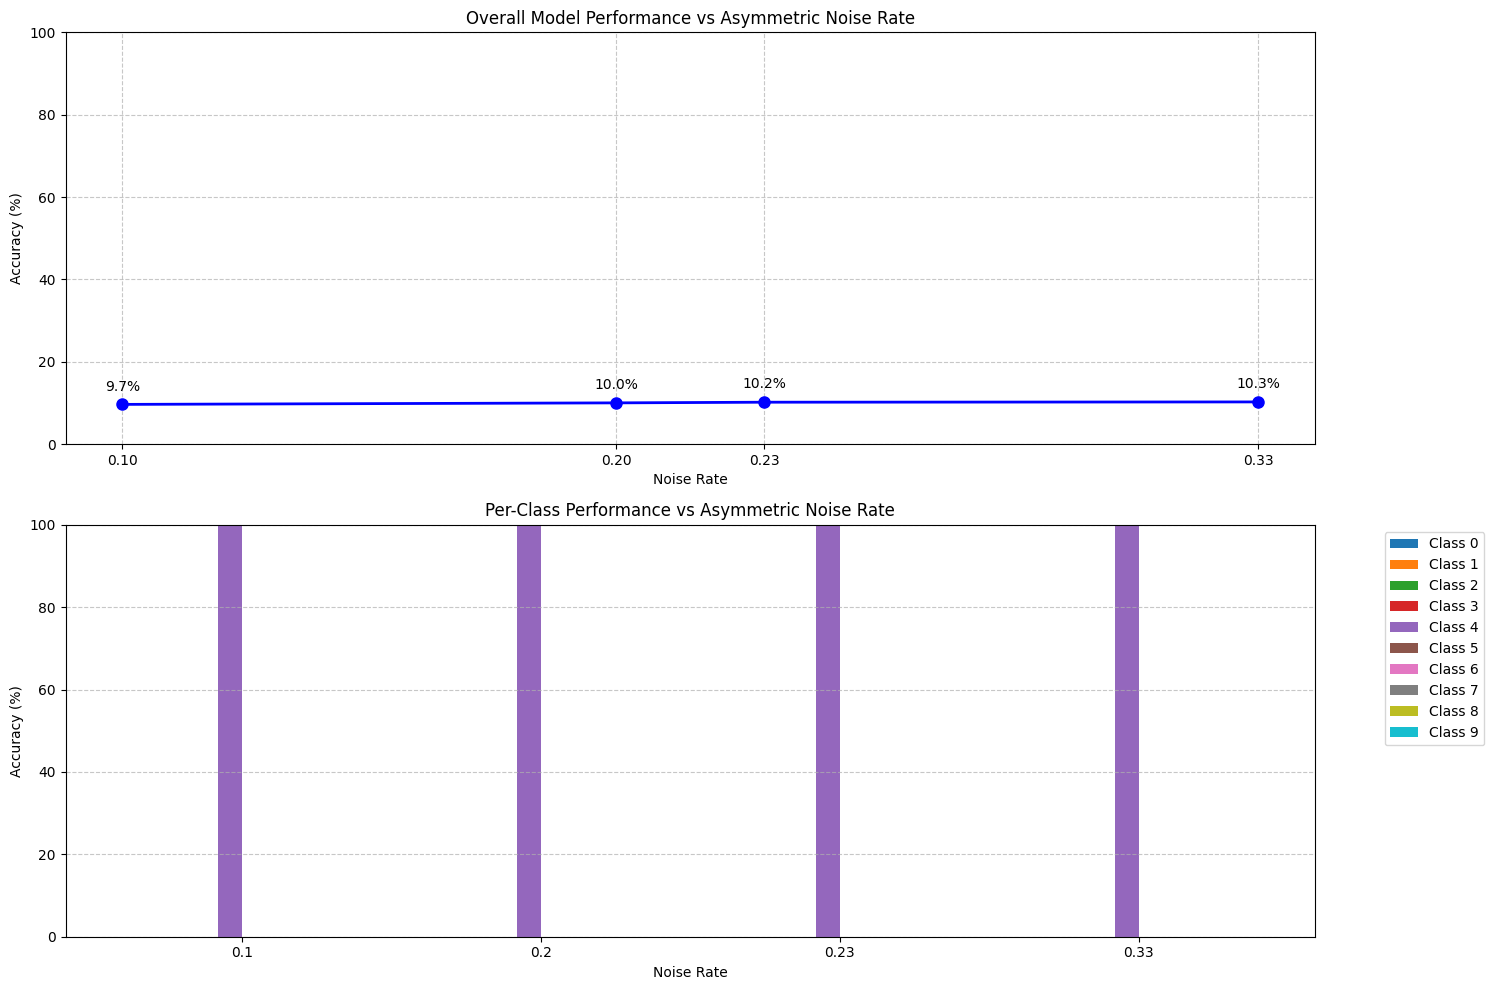


Numerical Results:

Overall Accuracy:
Noise Rate 0.1: 9.67%
Noise Rate 0.2: 10.04%
Noise Rate 0.23: 10.20%
Noise Rate 0.33: 10.27%

Per-Class Accuracy:

Class 0:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 1:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 2:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 3:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 4:
Noise Rate 0.1: 100.00%
Noise Rate 0.2: 100.00%
Noise Rate 0.23: 100.00%
Noise Rate 0.33: 100.00%

Class 5:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 6:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 7:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 8:
Noise Rate 0.1: 0.00%
Noise R

In [27]:
#Normalized Focal Entropy Loss
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
noise_levels = [0.2, 0.1, 0.33, 0.23]
for rate in noise_levels:
    noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
            

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch.detach().cpu().numpy()
            
            loss_trad = normalizedfocalloss(predictions, noisy_labels_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')


accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_levels:
        noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * test_loader.batch_size
            batch_end = batch_start + labels.size(0)
            target_labels = noisy_labels[batch_start:batch_end]

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j].item()
                pred = predicted[j].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        for i in range(10):
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] != 0 else 0
            class_accuracy_results[i][rate] = class_acc

plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Asymmetric Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: Per-class accuracy
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Asymmetric Noise Rate')
plt.xticks(x + width*4.5, x_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


<ipython-input-16-c3d75e85838a>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)


Noise Rate [0.2], Epoch [1/15], Step [2000/12500], Loss: 1.8626
Noise Rate [0.2], Epoch [1/15], Step [4000/12500], Loss: 1.8670
Noise Rate [0.2], Epoch [1/15], Step [6000/12500], Loss: 1.8644
Noise Rate [0.2], Epoch [1/15], Step [8000/12500], Loss: 1.8666
Noise Rate [0.2], Epoch [1/15], Step [10000/12500], Loss: 1.8640
Noise Rate [0.2], Epoch [1/15], Step [12000/12500], Loss: 1.8637
Noise Rate [0.2], Epoch [2/15], Step [2000/12500], Loss: 1.8626
Noise Rate [0.2], Epoch [2/15], Step [4000/12500], Loss: 1.8670
Noise Rate [0.2], Epoch [2/15], Step [6000/12500], Loss: 1.8644
Noise Rate [0.2], Epoch [2/15], Step [8000/12500], Loss: 1.8666
Noise Rate [0.2], Epoch [2/15], Step [10000/12500], Loss: 1.8640
Noise Rate [0.2], Epoch [2/15], Step [12000/12500], Loss: 1.8637
Noise Rate [0.2], Epoch [3/15], Step [2000/12500], Loss: 1.8626
Noise Rate [0.2], Epoch [3/15], Step [4000/12500], Loss: 1.8670
Noise Rate [0.2], Epoch [3/15], Step [6000/12500], Loss: 1.8644
Noise Rate [0.2], Epoch [3/15], Step

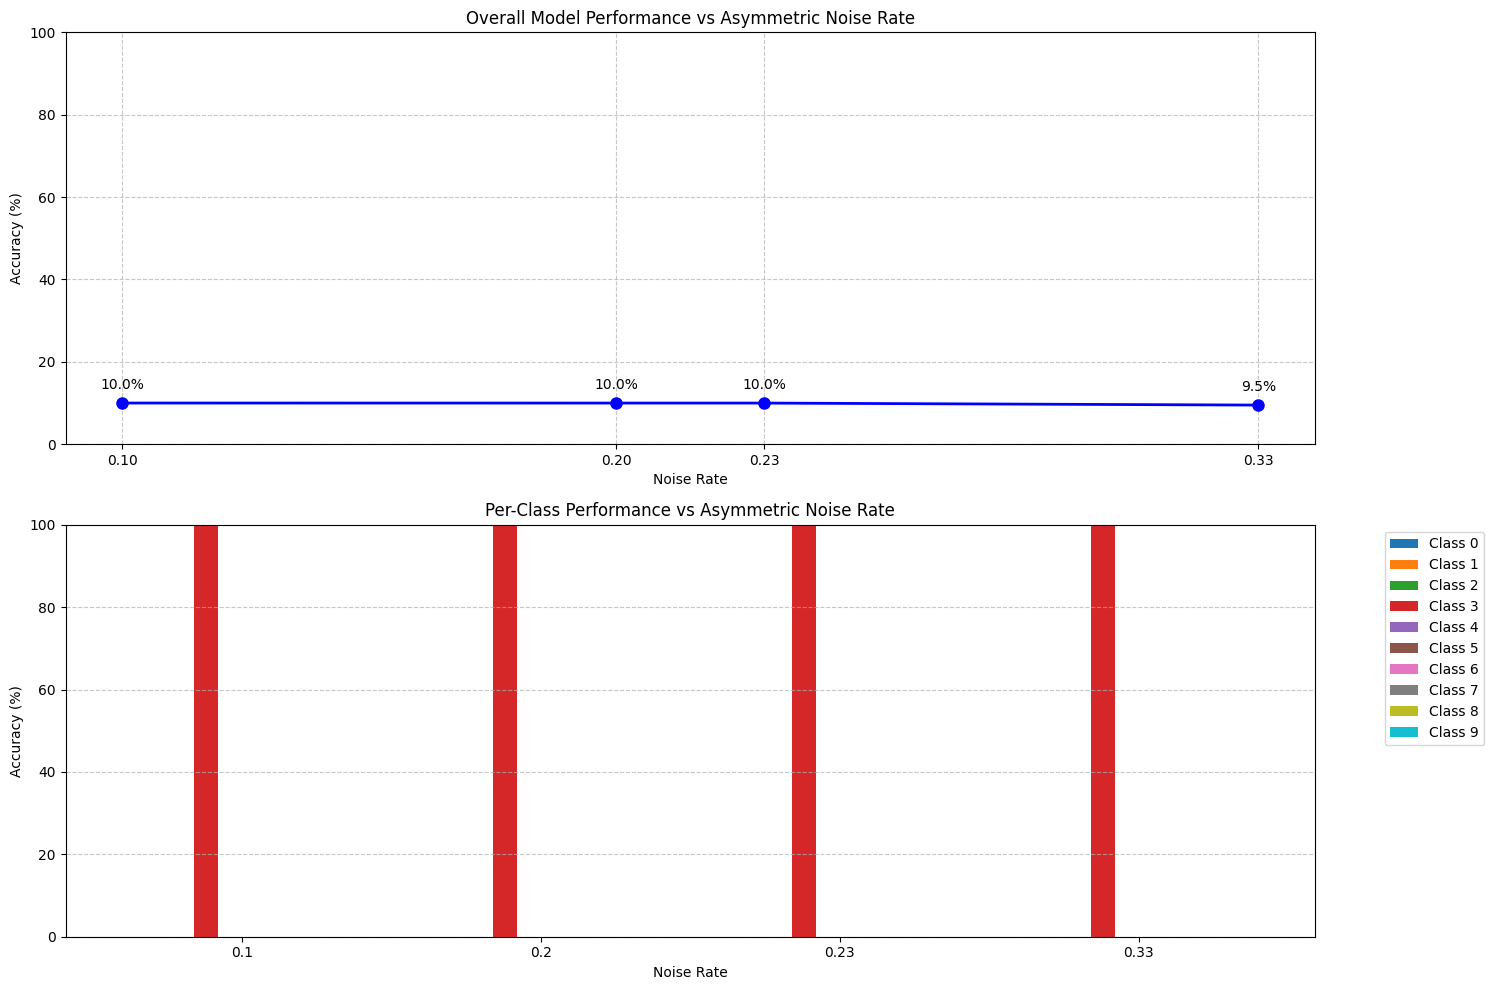


Numerical Results:

Overall Accuracy:
Noise Rate 0.1: 10.00%
Noise Rate 0.2: 9.99%
Noise Rate 0.23: 9.99%
Noise Rate 0.33: 9.50%

Per-Class Accuracy:

Class 0:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 1:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 2:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 3:
Noise Rate 0.1: 100.00%
Noise Rate 0.2: 100.00%
Noise Rate 0.23: 100.00%
Noise Rate 0.33: 100.00%

Class 4:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 5:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 6:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 7:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 8:
Noise Rate 0.1: 0.00%
Noise Rat

In [16]:
#For Focal loss-
criterion = FocalLoss(gamma=2)
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
noise_levels = [0.2, 0.1, 0.33, 0.23]
for rate in noise_levels:
    noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]


            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1)

            noisy_labels_np = noisy_labels_batch


            loss = criterion(predictions, noisy_labels_np)
            loss_trad = criterion(predictions, noisy_labels_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')

print('Finished Training with All Noisy Labels!')

accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_levels:
        noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * test_loader.batch_size
            batch_end = batch_start + labels.size(0)
            target_labels = noisy_labels[batch_start:batch_end]

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j].item()
                pred = predicted[j].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        for i in range(10):
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] != 0 else 0
            class_accuracy_results[i][rate] = class_acc

plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Asymmetric Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: Per-class accuracy
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Asymmetric Noise Rate')
plt.xticks(x + width*4.5, x_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


Noise Rate [0.2], Epoch [1/15], Step [2000/12500], Loss: -0.0894
Noise Rate [0.2], Epoch [1/15], Step [4000/12500], Loss: -0.0904
Noise Rate [0.2], Epoch [1/15], Step [6000/12500], Loss: -0.0902
Noise Rate [0.2], Epoch [1/15], Step [8000/12500], Loss: -0.0907
Noise Rate [0.2], Epoch [1/15], Step [10000/12500], Loss: -0.0909
Noise Rate [0.2], Epoch [1/15], Step [12000/12500], Loss: -0.0901
Noise Rate [0.2], Epoch [2/15], Step [2000/12500], Loss: -0.0894
Noise Rate [0.2], Epoch [2/15], Step [4000/12500], Loss: -0.0904
Noise Rate [0.2], Epoch [2/15], Step [6000/12500], Loss: -0.0902
Noise Rate [0.2], Epoch [2/15], Step [8000/12500], Loss: -0.0907
Noise Rate [0.2], Epoch [2/15], Step [10000/12500], Loss: -0.0909
Noise Rate [0.2], Epoch [2/15], Step [12000/12500], Loss: -0.0901
Noise Rate [0.2], Epoch [3/15], Step [2000/12500], Loss: -0.0894
Noise Rate [0.2], Epoch [3/15], Step [4000/12500], Loss: -0.0904
Noise Rate [0.2], Epoch [3/15], Step [6000/12500], Loss: -0.0902
Noise Rate [0.2], Epo

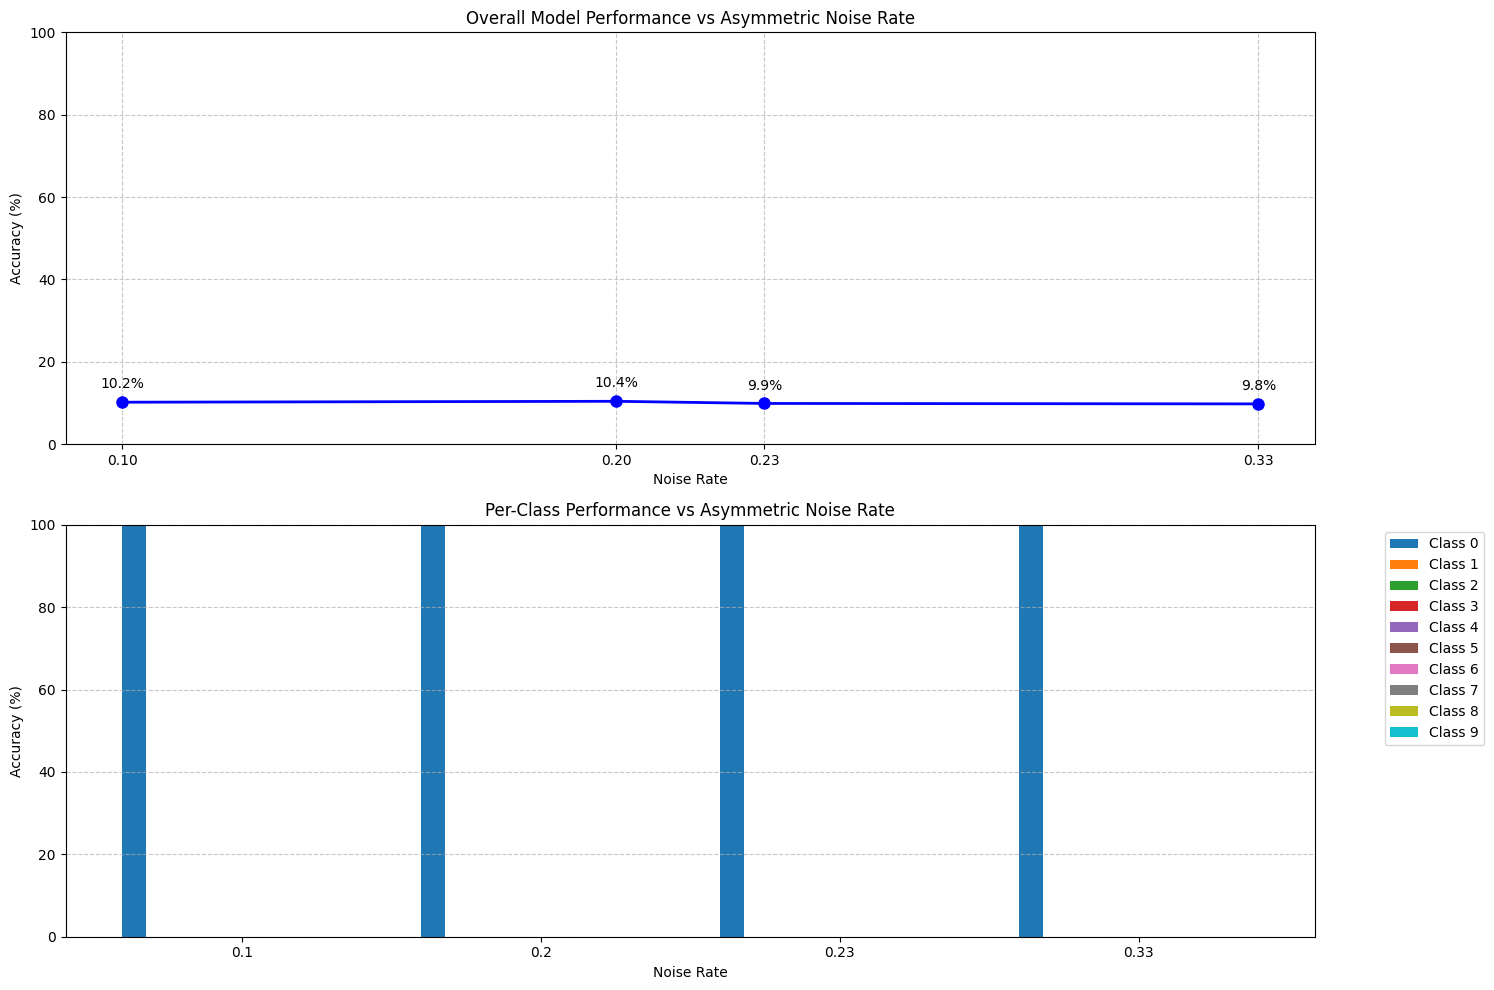


Numerical Results:

Overall Accuracy:
Noise Rate 0.1: 10.20%
Noise Rate 0.2: 10.42%
Noise Rate 0.23: 9.90%
Noise Rate 0.33: 9.79%

Per-Class Accuracy:

Class 0:
Noise Rate 0.1: 100.00%
Noise Rate 0.2: 100.00%
Noise Rate 0.23: 100.00%
Noise Rate 0.33: 100.00%

Class 1:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 2:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 3:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 4:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 5:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 6:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 7:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 8:
Noise Rate 0.1: 0.00%
Noise Ra

In [19]:
#For APL framework
model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)
noise_levels = [0.2, 0.1, 0.33, 0.23]
for rate in noise_levels:
    noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
           

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch.detach().cpu().numpy()
            

            loss_trad = APLNCEMAE(predictions, noisy_labels_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')


accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_levels:
        noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * test_loader.batch_size
            batch_end = batch_start + labels.size(0)
            target_labels = noisy_labels[batch_start:batch_end]

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j].item()
                pred = predicted[j].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        for i in range(10):
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] != 0 else 0
            class_accuracy_results[i][rate] = class_acc

plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Asymmetric Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: Per-class accuracy
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Asymmetric Noise Rate')
plt.xticks(x + width*4.5, x_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


Noise Rate [0.2], Epoch [1/15], Step [2000/12500], Loss: -0.0891
Noise Rate [0.2], Epoch [1/15], Step [4000/12500], Loss: -0.0914
Noise Rate [0.2], Epoch [1/15], Step [6000/12500], Loss: -0.0911
Noise Rate [0.2], Epoch [1/15], Step [8000/12500], Loss: -0.0885
Noise Rate [0.2], Epoch [1/15], Step [10000/12500], Loss: -0.0908
Noise Rate [0.2], Epoch [1/15], Step [12000/12500], Loss: -0.0920
Noise Rate [0.2], Epoch [2/15], Step [2000/12500], Loss: -0.0891
Noise Rate [0.2], Epoch [2/15], Step [4000/12500], Loss: -0.0914
Noise Rate [0.2], Epoch [2/15], Step [6000/12500], Loss: -0.0911
Noise Rate [0.2], Epoch [2/15], Step [8000/12500], Loss: -0.0885
Noise Rate [0.2], Epoch [2/15], Step [10000/12500], Loss: -0.0908
Noise Rate [0.2], Epoch [2/15], Step [12000/12500], Loss: -0.0920
Noise Rate [0.2], Epoch [3/15], Step [2000/12500], Loss: -0.0891
Noise Rate [0.2], Epoch [3/15], Step [4000/12500], Loss: -0.0914
Noise Rate [0.2], Epoch [3/15], Step [6000/12500], Loss: -0.0911
Noise Rate [0.2], Epo

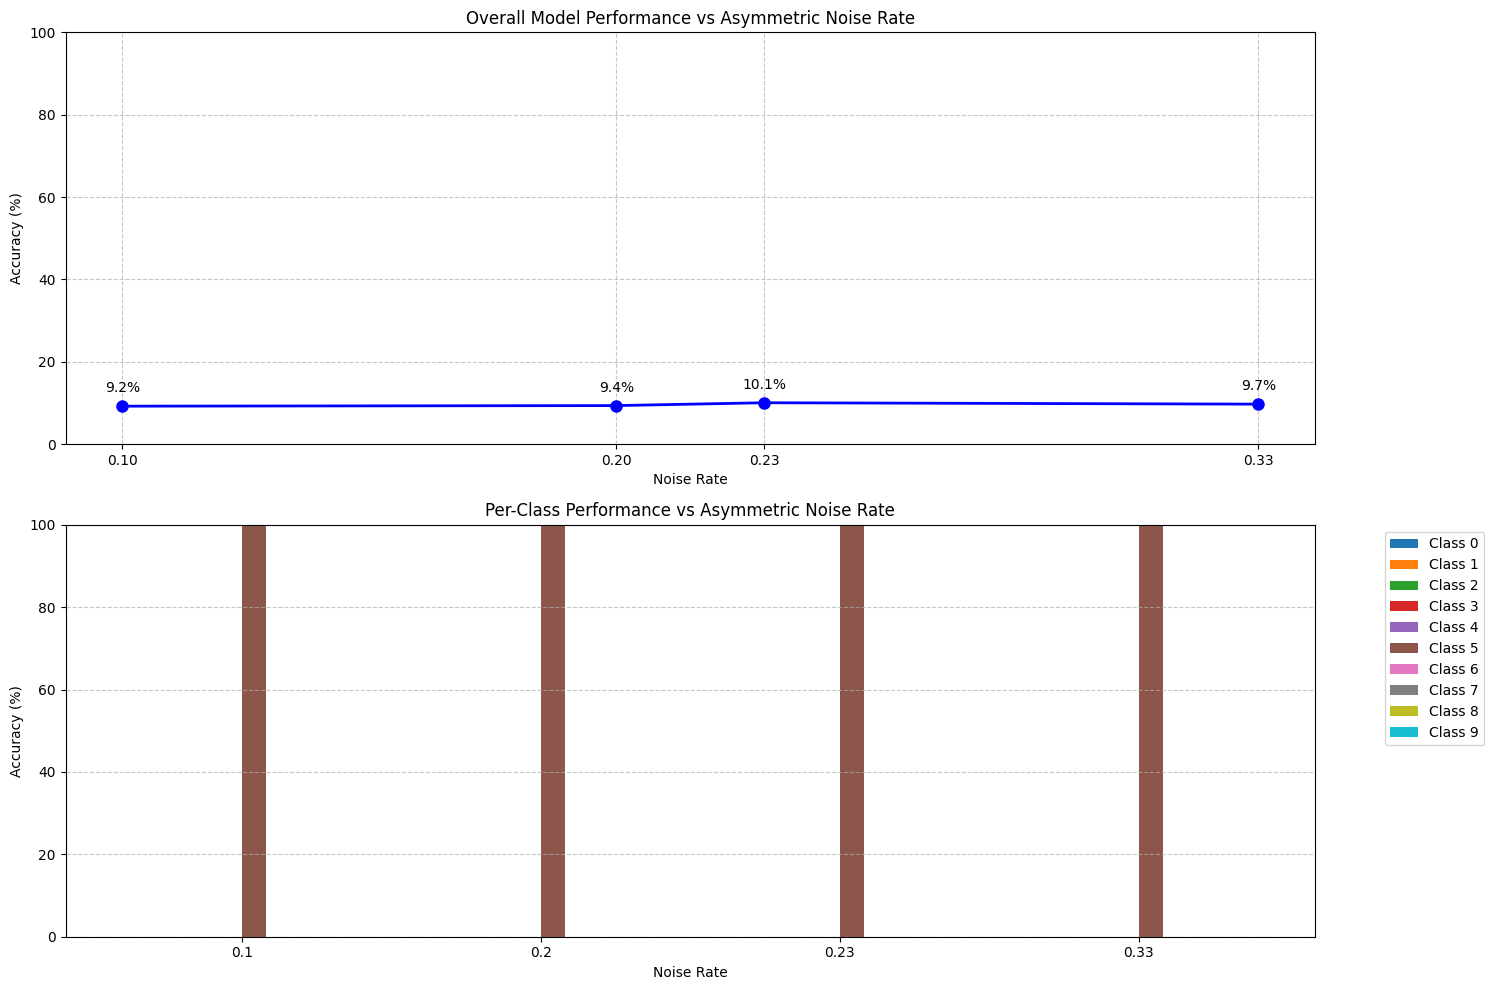


Numerical Results:

Overall Accuracy:
Noise Rate 0.1: 9.24%
Noise Rate 0.2: 9.38%
Noise Rate 0.23: 10.07%
Noise Rate 0.33: 9.73%

Per-Class Accuracy:

Class 0:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 1:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 2:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 3:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 4:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 5:
Noise Rate 0.1: 100.00%
Noise Rate 0.2: 100.00%
Noise Rate 0.23: 100.00%
Noise Rate 0.33: 100.00%

Class 6:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 7:
Noise Rate 0.1: 0.00%
Noise Rate 0.2: 0.00%
Noise Rate 0.23: 0.00%
Noise Rate 0.33: 0.00%

Class 8:
Noise Rate 0.1: 0.00%
Noise Rat

In [20]:

model = ConvNet().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
n_total_steps = len(train_loader)

noise_levels = [0.2, 0.1, 0.33, 0.23]
for rate in noise_levels:
    noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

    for epoch in range(num_epoches):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_indices = i * train_loader.batch_size + np.arange(images.size(0))
            noisy_labels_batch = noisy_labels[batch_indices]
           

            outputs = model(images)
            predictions = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            noisy_labels_np = noisy_labels_batch.detach().cpu().numpy()
            

            loss_trad = APLNFLMAE(predictions, noisy_labels_np)

            optimizer.zero_grad()
            #total_loss = torch.tensor(loss + loss_trad, requires_grad=True).to(device)
            loss_trad=torch.tensor(loss_trad,requires_grad=True).to(device)
            loss_trad.backward()
            optimizer.step()

            if (i + 1) % 2000 == 0:
                 print(f'Noise Rate [{rate}], Epoch [{epoch+1}/{num_epoches}], Step [{i+1}/{n_total_steps}], Loss: {loss_trad.item():.4f}')


accuracy_results = {}
class_accuracy_results = {i: {} for i in range(10)}

with torch.no_grad():
    for rate in noise_levels:
        noisy_labels = torch.tensor(noisy_labels_dict2[rate]).to(device)  # Asymmetric noisy labels

        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for _ in range(10)]
        n_class_samples = [0 for _ in range(10)]

        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            batch_start = i * test_loader.batch_size
            batch_end = batch_start + labels.size(0)
            target_labels = noisy_labels[batch_start:batch_end]

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == target_labels).sum().item()

            for j in range(labels.size(0)):
                label = target_labels[j].item()
                pred = predicted[j].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        acc = 100.0 * n_correct / n_samples
        accuracy_results[rate] = acc

        for i in range(10):
            class_acc = 100.0 * n_class_correct[i] / n_class_samples[i] if n_class_samples[i] != 0 else 0
            class_accuracy_results[i][rate] = class_acc

plt.figure(figsize=(15, 10))

# Plot 1: Overall accuracy
plt.subplot(2, 1, 1)
x_values = sorted(accuracy_results.keys())
y_values = [accuracy_results[rate] for rate in x_values]

plt.plot(x_values, y_values, 'b-', marker='o', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x_values)
plt.ylim(0, 100)
plt.title('Overall Model Performance vs Asymmetric Noise Rate')
plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')

for x, y in zip(x_values, y_values):
    plt.annotate(f'{y:.1f}%', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Plot 2: Per-class accuracy
plt.subplot(2, 1, 2)
x = np.arange(len(x_values))
width = 0.08
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in range(10):
    class_accuracies = [class_accuracy_results[i][rate] for rate in x_values]
    plt.bar(x + i*width, class_accuracies, width, label=f'Class {i}', color=colors[i])

plt.xlabel('Noise Rate')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Performance vs Asymmetric Noise Rate')
plt.xticks(x + width*4.5, x_values)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("\nOverall Accuracy:")
for rate in x_values:
    print(f"Noise Rate {rate}: {accuracy_results[rate]:.2f}%")

print("\nPer-Class Accuracy:")
for i in range(10):
    print(f"\nClass {i}:")
    for rate in x_values:
        print(f"Noise Rate {rate}: {class_accuracy_results[i][rate]:.2f}%")


Core ML assignment by Tanmay S. Joshi(2023A4PS1102G)
